# Анализ и прогнозирование временных рядов методами искусственного интеллекта

## **Практическая работа 1. Метрики и меры схожести между временными рядами.**

Смените рабочую директорию с помощью команды `chdir()`. Для этого передайте этой команде свой путь до каталога, в котором содержатся материалы первой практической работы. После выполнения этой команды все последующие операции с файлами и каталогами будут производиться относительно указанного каталога.

In [1]:
import os

practice_dir_path = 'C:/Users/Hotaru/Basics'
os.chdir(practice_dir_path)

Выполните команды, которые автоматически перезагружают все импортированные модули при их изменении.

In [2]:
%load_ext autoreload
%autoreload 2

Импортируйте библиотеки и модули, необходимые для реализации практической работы 1.

In [3]:
!pip install sktime

In [9]:
import numpy as np
import random
from sktime.distances import euclidean_distance, dtw_distance, pairwise_distance
from sklearn.metrics import silhouette_score
import cv2
import imutils
import glob
import matplotlib.pyplot as plt

from modules.metrics import ED_distance, norm_ED_distance, DTW_distance
from modules.pairwise_distance import PairwiseDistance
from modules.clustering import TimeSeriesHierarchicalClustering
from modules.classification import TimeSeriesKNN, calculate_accuracy

from modules.utils import read_ts, z_normalize, sliding_window, random_walk
from modules.plots import plot_ts

## **Часть 1.** Функции расстояния: евклидова метрика и DTW мера. Матрица расстояний. Иерархическая кластеризация временных рядов.

### **Задача 1.**
Реализуйте самостоятельно функцию `ED_distance()` в модуле *metrics.py*, которая вычисляет евклидово расстояние между двумя временными рядами, имеющими одинаковую длину. В качестве входных данных передайте в функцию два синтетических временных ряда некоторой заданной вами длины. Для их генерации используйте функцию `random_walk()` из модуля *utils.py*,  реализующую модель случайных блужданий (Random Walk), или стандартный модуль *random*.

**Евклидово расстояние** между двумя временными рядами $T_1$ и $T_2$ длины $n$ вычисляется следующим образом:

\begin{equation}
    \text{ED}(T_1, T_2) = \sqrt{\sum_{i=1}^{n} ({t_{1}}_i-{t_{2}}_i)^2}.
\end{equation}

Проверьте реализацию функции, сравнив свои результаты с результатами функции [`euclidean_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.euclidean_distance.html) из библиотеки *sktime*, с помощью `test_distances()`.

In [23]:
import numpy as np
from sktime.distances import euclidean_distance
from modules.utils import random_walk  # Убедитесь, что функция random_walk реализована
from modules.metrics import ED_distance  # Импортируем вашу функцию ED_distance

def test_distances(dist1: float, dist2: float) -> None:
    """
    Check whether your distance function is implemented correctly

    Parameters
    ----------
    dist1 : distance between two time series calculated by sktime
    dist2 : distance between two time series calculated by your function
    """
    np.testing.assert_equal(round(dist1, 5), round(dist2, 5), 'Distances are not equal')

# Генерация синтетических временных рядов
length = 100  # Длина временных рядов
T1 = random_walk(length)  # Первый синтетический временной ряд
T2 = random_walk(length)  # Второй синтетический временной ряд

# Вычисление расстояний
dist1 = euclidean_distance(T1, T2)  # Расстояние по sktime
dist2 = ED_distance(T1, T2)          # Расстояние по вашей функции

# Тестирование расстояний
test_distances(dist1, dist2)

print("Distances are equal!")


Distances are equal!


In [22]:
import numpy as np

def ED_distance(ts1: np.ndarray, ts2: np.ndarray) -> float:
    """
    Calculate the Euclidean distance

    Parameters
    ----------
    ts1: the first time series
    ts2: the second time series

    Returns
    -------
    ed_dist: euclidean distance between ts1 and ts2
    """
    
    if len(ts1) != len(ts2):
        raise ValueError("Time series must be of the same length.")
        
    # Calculate the Euclidean distance
    ed_dist = np.sqrt(np.sum((ts1 - ts2) ** 2))
    
    return ed_dist

### **Задача 2.**

Реализуйте самостоятельно функцию `DTW_distance()` в модуле *metrics.py*, которая вычисляет DTW расстояние между двумя временными рядами, имеющими одинаковую длину. Для вычисления расстояния между элементами временных рядов в DTW мере используйте евклидово расстояние. Временные ряды сгенерируйте аналогичным образом, как в задаче 1, или используйте уже созданные.

**Динамическая трансформация временной шкалы (Dynamic Time Warping, DTW)** – мера схожести между двумя временными рядами $T_1$ и $T_2$ длины $n$, вычисляемая следующим образом:

\begin{equation}
\text{DTW}(T_1, T_2) = d(n,n),
\\ d(i,j) = ({t_{1}}_i - {t_{2}}_j)^2 + \min \left\{
	\begin{array}{l l}
	d(i-1,j), \\
	d(i,j-1), \\
	d(i-1,j-1),
	\end{array}
	\right.
\\ d(0,0)=0, \quad d(i,0)=d(0,j)=\infty, \quad  1 \leqslant i,j \leqslant n.
\end{equation}

Сравните свои результаты с результатами функции [`dtw_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.dtw_distance.html) из библиотеки *sktime*. Для этого используйте `test_distances()` из задачи 1.

In [28]:
from sktime.distances import dtw_distance as sktime_dtw_distance
from modules.utils import random_walk  # Убедитесь, что эта функция доступна
from modules.metrics import DTW_distance

# Генерация синтетических временных рядов
length = 100
T1 = random_walk(length)
T2 = random_walk(length)

# Вычисление расстояний
dist1 = sktime_dtw_distance(T1, T2)  # Расстояние по sktime
dist2 = DTW_distance(T1, T2)          # Расстояние по вашей функции

# Тестирование расстояний
test_distances(dist1, dist2)

print("DTW distances are equal!")


DTW distances are equal!


In [29]:
def DTW_distance(ts1: np.ndarray, ts2: np.ndarray) -> float:
    """
    Calculate DTW distance using a square difference metric.

    Parameters
    ----------
    ts1: first time series
    ts2: second time series

    Returns
    -------
    dtw_dist: DTW distance between ts1 and ts2
    """
    
    n, m = len(ts1), len(ts2)

    # Инициализация матрицы DTW
    dtw_matrix = np.full((n + 1, m + 1), np.inf)  # Заполнение матрицы бесконечностями
    dtw_matrix[0, 0] = 0  # Начальная точка

    # Заполнение матрицы
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = (ts1[i - 1] - ts2[j - 1]) ** 2  # Квадрат разности
            # Вычисление D(i, j)
            dtw_matrix[i, j] = cost + min(
                dtw_matrix[i - 1, j],    # Вверх
                dtw_matrix[i, j - 1],    # Влево
                dtw_matrix[i - 1, j - 1] # Влево-вверх
            )

    dtw_dist = dtw_matrix[n, m]  # Получение DTW расстояния
    return dtw_dist

### **Задача 3.**
Реализуйте нахождение матрицы расстояний между несколькими временными рядами.
Для этого заполните все методы c недостающим кодом в классе `PairwiseDistance` из модуля *pairwise_distance.py*. Для вычисления расстояний между рядами используйте ранее реализованные вами функции `ED_distance()` и `DTW_distance()` из модуля *metrics.py*.

Матрица расстояний между временными рядами определяется следующим образом. Пусть дано множество $S$, состоящее из $K$ временных рядов длины $n$: $\;S = \{T_1, T_2, ..., T_K\}, \; T_i \in \mathbb{R}^n$. Тогда под **матрицей расстояний** $D \in \mathbb{R}^{K \times K}$ понимается квадратная матрица, где каждый ее элемент $d(i,j)$ представляет собой расстояние между временными рядами $T_i$ и $T_j$ из множества $S$:
\begin{equation}
d(i,j) = dist(T_i, T_j), \quad T_i, T_j \in S, \quad 1 \leqslant i,j \leqslant K.
\end{equation}

Поскольку евклидова метрика и DTW мера удовлетворяют аксиоме симметричности (т.е. $dist(T_i, T_j)=dist(T_j, T_i)$), то матрица расстояний $D$ будет симметричной относительно главной диагонали. Для ускорения вычислений достаточно найти ее верхний треугольник, а нижний треугольник матрицы заполнить значениями верхнего треугольника следующим образом:
\begin{equation}
d(j,i) = d(i,j), \; где \; i < j.
\end{equation}

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/01%20Basics/img/distance_matrix.png?raw=true" width="600"></center>

Сгенерируйте множество, состоящее из $K$ временных рядов некоторой длины $n$. Вычислите матрицы евклидовых и DTW расстояний между ними. Проверьте реализованные вами методы, сравнив свои результаты с результатами функции [`pairwise_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.pairwise_distance.html) из библиотеки *sktime*.

In [31]:
import numpy as np
from sktime.distances import pairwise_distance
from modules.metrics import ED_distance, DTW_distance
from modules.pairwise_distance import PairwiseDistance

def test_matrices(matrix1: np.ndarray, matrix2: np.ndarray) -> None:
    """
    Check whether your matrix function is implemented correctly

    Parameters
    ----------
    matrix1 : distance matrix calculated by sktime
    matrix2 : distance matrix calculated by your function
    """
    np.testing.assert_equal(matrix1.round(5), matrix2.round(5), 'Matrices are not equal')

# Генерация случайных временных рядов
K = 5  # Количество временных рядов
n = 100  # Длина временных рядов
temporal_series = np.random.rand(K, n)  # Случайные временные ряды размера K x n

# Вычисление матриц расстояний с помощью sktime
sktime_distance_euclidean = pairwise_distance(temporal_series, metric='euclidean')
sktime_distance_dtw = pairwise_distance(temporal_series, metric='dtw')

# Вычисление матриц расстояний с помощью вашей реализации
pairwise_distance_instance = PairwiseDistance(metric='euclidean')
your_distance_euclidean = pairwise_distance_instance.calculate(temporal_series)

pairwise_distance_instance = PairwiseDistance(metric='dtw')
your_distance_dtw = pairwise_distance_instance.calculate(temporal_series)

# Тестирование матриц расстояний
test_matrices(sktime_distance_euclidean, your_distance_euclidean)
test_matrices(sktime_distance_dtw, your_distance_dtw)

print("All distance matrices are equal!")


All distance matrices are equal!


In [ ]:
class PairwiseDistance:
    """
    Distance matrix between time series 

    Parameters
    ----------
    metric: distance metric between two time series
            Options: {euclidean, dtw}
    is_normalize: normalize or not time series
    """

    def __init__(self, metric: str = 'euclidean', is_normalize: bool = False) -> None:
        self.metric: str = metric
        self.is_normalize: bool = is_normalize

    @property
    def distance_metric(self) -> str:
        """Return the distance metric

        Returns
        -------
            string with metric which is used to calculate distances between set of time series
        """
        norm_str = "normalized " if self.is_normalize else "non-normalized "
        return norm_str + self.metric + " distance"

    def _choose_distance(self):
        """ Choose distance function for calculation of matrix
        
        Returns
        -------
        dist_func: function reference
        """
        if self.metric == 'euclidean':
            return ED_distance
        elif self.metric == 'dtw':
            return DTW_distance
        else:
            raise ValueError(f"Unknown metric: {self.metric}. Use 'euclidean' or 'dtw'.")

    def calculate(self, input_data: np.ndarray) -> np.ndarray:
        """ Calculate distance matrix
        
        Parameters
        ----------
        input_data: time series set
        
        Returns
        -------
        matrix_values: distance matrix
        """
        
        matrix_shape = (input_data.shape[0], input_data.shape[0])
        matrix_values = np.zeros(matrix_shape)

        # Нормализация временных рядов, если требуется
        if self.is_normalize:
            input_data = np.array([z_normalize(ts) for ts in input_data])

        # Выбор функции расстояния
        dist_func = self._choose_distance()

        # Заполнение верхнего треугольника матрицы расстояний
        for i in range(matrix_shape[0]):
            for j in range(i + 1, matrix_shape[1]):
                matrix_values[i, j] = dist_func(input_data[i], input_data[j])
                matrix_values[j, i] = matrix_values[i, j]  # Симметричность

        return matrix_values

### **Задача 4.**
Далее рассмотрим задачу иерархической кластеризации временных рядов, где будет использоваться предвычисленная матрица расстояний.

Для этого сначала загрузите набор временных рядов CBF из файла *CBF_TRAIN.txt*, который располагается в директории *./datasets/part1*. Каждая строка данного файла содержит целевую переменную (класс: 0, 1 или 2) в первом столбце и временной ряд в остальных столбцах. Набор CBF является синтетическим и включает в себя 30 временных рядов,  каждый из которых принадлежит к одному из трех классов.

In [99]:
url = './datasets/part1/CBF_TRAIN.txt'

data = read_ts(url)

ts_set = data.iloc[:, 1:]
labels = data.iloc[:, 0]

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

Выполните визуализацию по одному временному ряду из каждого класса. Для этого используйте функцию `plot_ts()` из модуля *plots.py*.

In [102]:
import numpy as np
from modules.utils import read_ts  # Замените на правильный импорт вашей функции чтения данных
from modules.plots import plot_ts  # Импорт функции визуализации

# Загрузка данных
url = './datasets/part1/CBF_TRAIN.txt'
data = read_ts(url)

# Предполагаем, что data — это массив NumPy (например, 2D массив)
# Извлечение меток и временных рядов
labels = data[:, 0]  # Первая колонка как метки
ts_set = data[:, 1:]  # Остальные колонки как временные ряды

# Получение уникальных классов
unique_labels = np.unique(labels)

# Визуализация одного временного ряда из каждого класса
for label in unique_labels:
    # Находим индексы для текущего класса
    class_indices = np.where(labels == label)[0]

    # Выбираем случайный временной ряд из данного класса
    random_index = np.random.choice(class_indices)

    # Визуализация временного ряда (оборачиваем в массив, чтобы получить 2D)
    plot_ts(ts_set[random_index].reshape(1, -1), plot_title=f'Time Series for Class {int(label)}')


Selected Time Series (Class 1):
Length: (128,), First 5 values: [-1.0860401 -1.1993047 -1.1205787 -1.196342  -1.9522055]
Any NaN values: False
Any Infinite values: False
Value range: -1.9522055 to 1.5433801


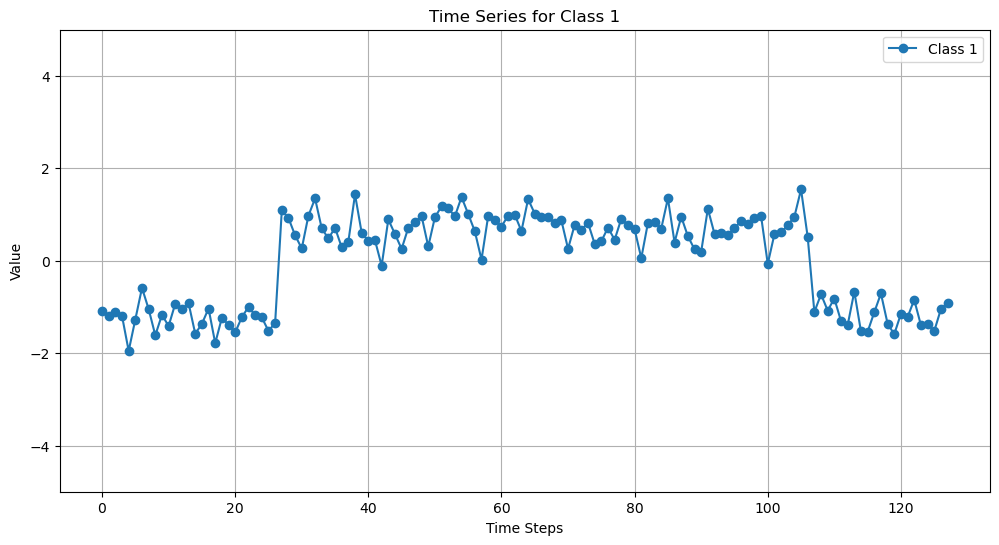

Selected Time Series (Class 2):
Length: (128,), First 5 values: [-1.1360166  -1.3191953  -1.8446238  -0.78869178 -0.2517154 ]
Any NaN values: False
Any Infinite values: False
Value range: -1.8446238 to 2.1533316


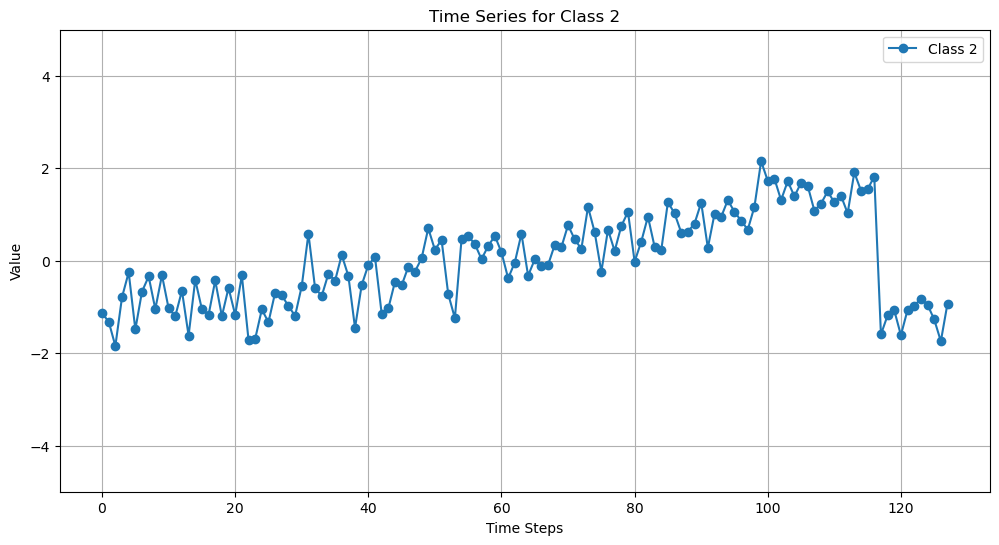

Selected Time Series (Class 3):
Length: (128,), First 5 values: [-0.19092144 -0.61605133 -0.59802857 -0.62544699 -0.15250752]
Any NaN values: False
Any Infinite values: False
Value range: -1.6866007 to 2.8985263


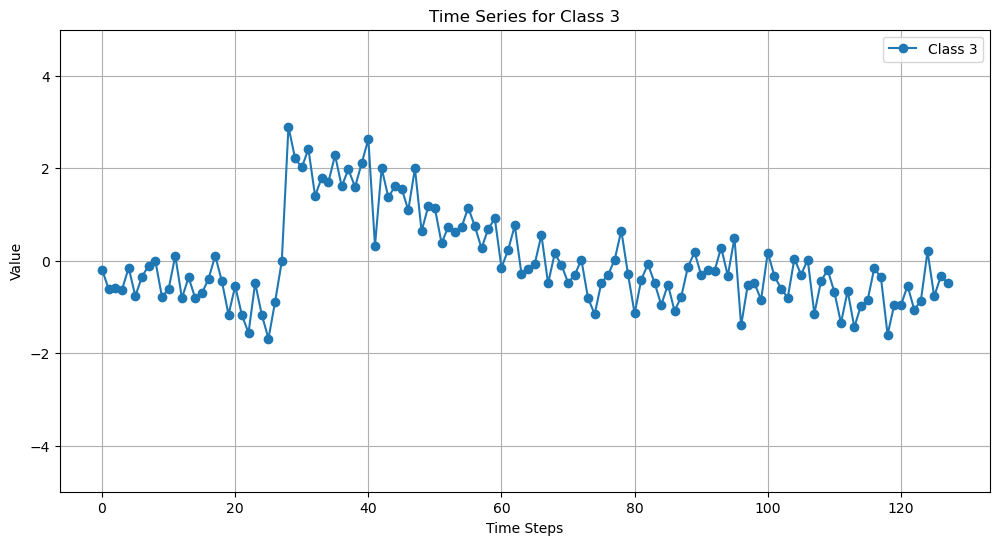

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from modules.utils import read_ts  # Импортируйте вашу функцию чтения данных

# Загрузка данных
url = './datasets/part1/CBF_TRAIN.txt'
data = read_ts(url)

# Извлечение меток и временных рядов
labels = data[:, 0]
ts_set = data[:, 1:]

# Получение уникальных классов
unique_labels = np.unique(labels)

# Визуализация одного временного ряда из каждого класса
for label in unique_labels:
    class_indices = np.where(labels == label)[0]
    random_index = np.random.choice(class_indices)
    selected_ts = ts_set[random_index]

    print(f"Selected Time Series (Class {int(label)}):")
    print(f"Length: {selected_ts.shape}, First 5 values: {selected_ts[:5]}")
    print(f"Any NaN values: {np.isnan(selected_ts).any()}")
    print(f"Any Infinite values: {np.isinf(selected_ts).any()}")
    print(f"Value range: {selected_ts.min()} to {selected_ts.max()}")

    plt.figure(figsize=(12, 6))
    plt.plot(selected_ts, label=f'Class {int(label)}', marker='o')  # Добавим маркеры
    plt.title(f'Time Series for Class {int(label)}')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.ylim(-5, 5)  # Настройте значения в зависимости от ваших данных
    plt.grid()
    plt.legend()
    plt.show()


Далее самостоятельно реализуйте класс `TimeSeriesHierarchicalClustering` из модуля *clustering.py*, который выполняет иерархическую кластеризацию временных рядов.

Перед тем как приступить к реализации, изучите скелет этого класса. Реализуйте метод `fit()`, выполняющий кластеризацию данных на основе предвычисленной матрицы расстояний, которая передается в данный метод. Поскольку реализовать иерархическую кластеризацию довольно сложно, используйте готовую реализацию [`AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) из *sklearn*.   

Выполните иерархическую кластеризацию загруженных временных рядов CBF для двух функций расстояния: евлидовой метрики и DTW меры.
Для этого сначала найдите матрицы расстояний между временными рядами, используя класс `PairwiseDistance`, и передайте каждую матрицу в метод `fit()` для кластеризации.
Далее выполните визуализацию результатов в виде дендрограмм с помощью метода `plot_dendrogram()`, передав исходный набор временных рядов и их метки.

C:\Users\Hotaru\anaconda3\envs\keras_env\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead

C:\Users\Hotaru\Basics\modules\clustering.py:63: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

C:\Users\Hotaru\anaconda3\envs\keras_env\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead

C:\Users\Hotaru\Basics\modules\clustering.py:63: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



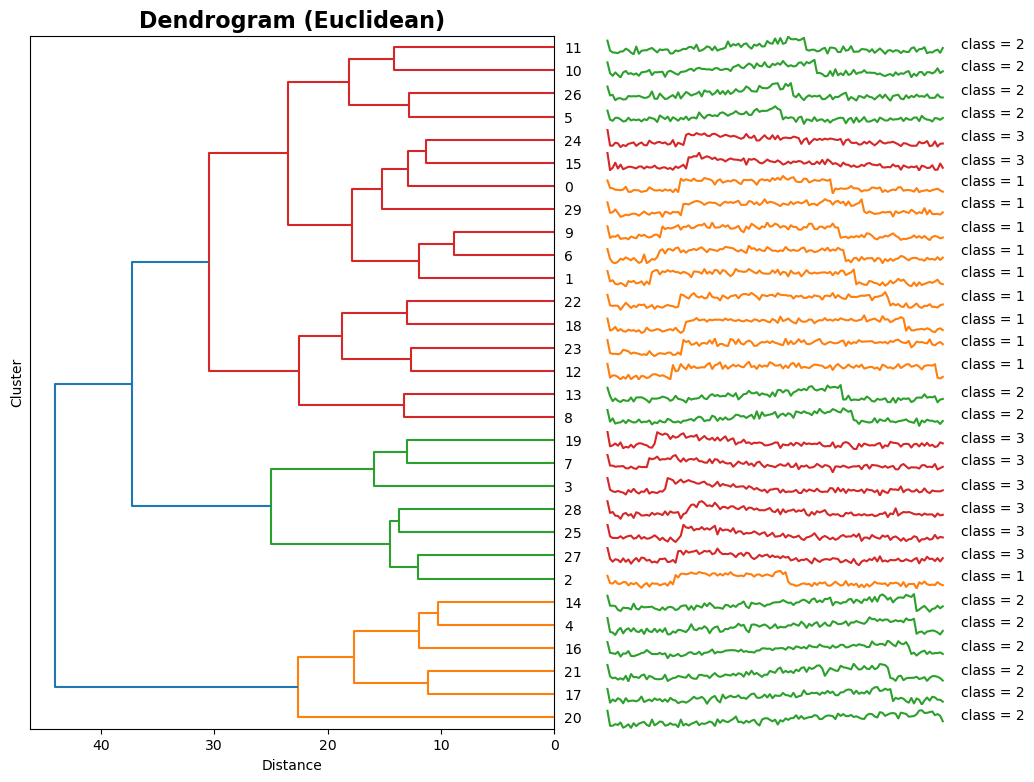

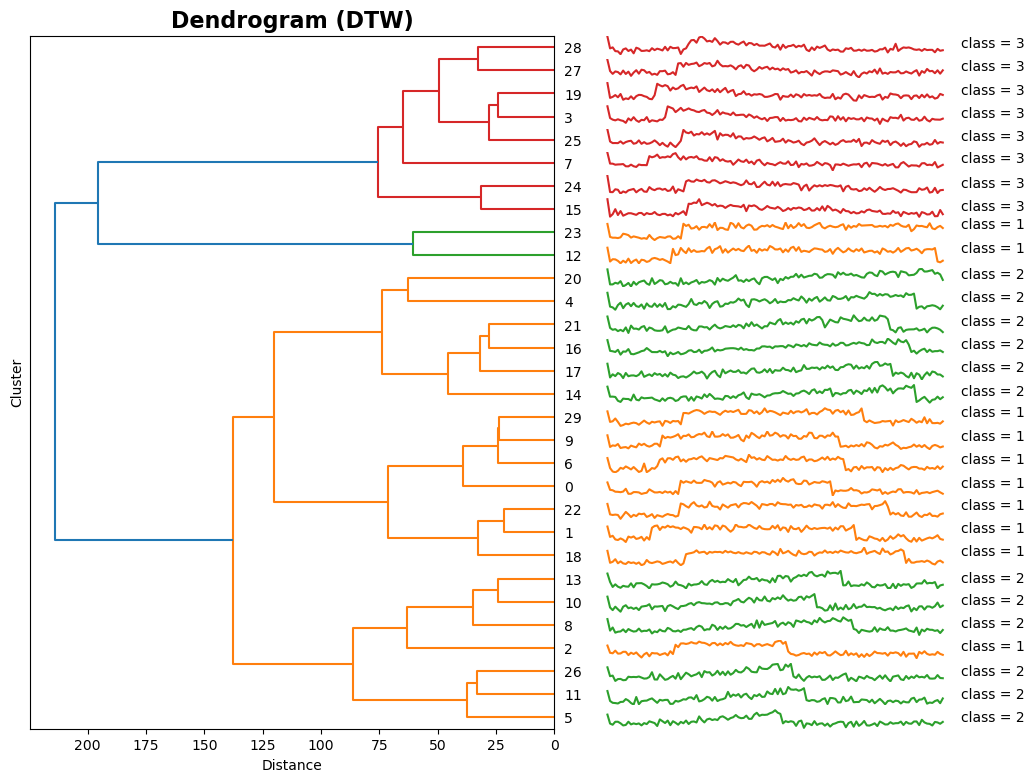

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modules.utils import read_ts  # Убедитесь, что у вас есть функция чтения данных
from modules.pairwise_distance import PairwiseDistance  # Ваш класс для расчета расстояний
from modules.clustering import TimeSeriesHierarchicalClustering  # Убедитесь, что класс импортирован

# Загрузка данных
url = './datasets/part1/CBF_TRAIN.txt'
data = read_ts(url)

# Преобразование в DataFrame, если еще не в формате DataFrame
if isinstance(data, np.ndarray):
    data = pd.DataFrame(data)

# Извлечение меток и временных рядов
labels = data.iloc[:, 0].values.astype(int)  # Используем iloc для извлечения меток
ts_set = data.iloc[:, 1:].values  # Все временные ряды

# Кластеризация с использованием евклидовой метрики
pairwise_ed = PairwiseDistance(metric='euclidean', is_normalize=False)
distance_matrix_ed = pairwise_ed.calculate(ts_set)

# Применение кластеризации
clustering_ed = TimeSeriesHierarchicalClustering(n_clusters=3, method='complete')
clustering_ed.fit(distance_matrix_ed)

# Визуализация дендрограммы для евклидовой метрики
clustering_ed.plot_dendrogram(data, labels, ts_hspace=12, title='Dendrogram (Euclidean)')

# Кластеризация с использованием DTW
pairwise_dtw = PairwiseDistance(metric='dtw', is_normalize=False)
distance_matrix_dtw = pairwise_dtw.calculate(ts_set)

# Применение кластеризации
clustering_dtw = TimeSeriesHierarchicalClustering(n_clusters=3, method='complete')
clustering_dtw.fit(distance_matrix_dtw)

# Визуализация дендрограммы для DTW
clustering_dtw.plot_dendrogram(data, labels, ts_hspace=12, title='Dendrogram (DTW)')


Сравните результаты иерархической кластеризации, полученные при двух различных функций расстояния, с помощью силуэтного коэффициента. Для этого используйте функцию [`silhouette_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) из библиотеки *sklearn*, передав в нее предвычисленную матрицу расстояний и предсказанные метки.

**Силуэтный коэффициент** – метрика, которая оценивает качество кластеризации на основе исходной выборки и результатов кластеризации без необходимости знания об истинных метках объектов.

Силуэтный коэффициент для выборки показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Пусть дана выборка $X$, состоящая из $N$ объектов. Предположим, что объекты этой выборки были разбиты на кластеры $c_1, ... c_K$, $c_i \in C$, с помощью некоторого алгоритма кластеризации. Тогда силуэтный коэффициент для выборки будет вычисляться следующим образом:

\begin{equation}
sil\_coef = \frac{1}{N} \sum_{c_k \in C} \sum_{x_i \in c_k} \frac{b(x_i, c_k) - a(x_i, c_k)}{\max(a(x_i, c_k), b(x_i, c_k))},
\end{equation}

где $a(x_i, c_k)$ – среднее расстояние от объекта $x_i \in c_k$ до других объектов из этого же кластера $c_k$; <br> $b(x_i, c_k)$  – среднее расстояние от объекта $x_i \in c_k$ до объектов из другого кластера $c_l$, $k \neq l$.

Силуэтный коэффициент принимает значения от  −1  до  1:
*   –1 означает, что кластеры плохие, размытые;
*   0 означает, что кластеры накладываются друг на друга;
*   1 означает, что кластеры плотные и хорошо отделены друг от друга.

Таким образом, чем ближе значение коэффициента к 1, тем лучше кластеризованы данные.

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from modules.utils import read_ts  # Убедитесь, что у вас есть функция чтения данных
from modules.pairwise_distance import PairwiseDistance  # Ваш класс для расчета расстояний
from modules.clustering import TimeSeriesHierarchicalClustering  # Убедитесь, что класс импортирован

# Загрузка данных
url = './datasets/part1/CBF_TRAIN.txt'
data = read_ts(url)

# Преобразование в DataFrame, если еще не в формате DataFrame
if isinstance(data, np.ndarray):
    data = pd.DataFrame(data)

# Извлечение меток и временных рядов
labels = data.iloc[:, 0].values.astype(int)  # Используем iloc для извлечения меток
ts_set = data.iloc[:, 1:].values  # Все временные ряды

# Кластеризация с использованием евклидовой метрики
pairwise_ed = PairwiseDistance(metric='euclidean', is_normalize=False)
distance_matrix_ed = pairwise_ed.calculate(ts_set)

clustering_ed = TimeSeriesHierarchicalClustering(n_clusters=3, method='complete')
labels_ed = clustering_ed.fit(distance_matrix_ed)

# Кластеризация с использованием DTW
pairwise_dtw = PairwiseDistance(metric='dtw', is_normalize=False)
distance_matrix_dtw = pairwise_dtw.calculate(ts_set)

clustering_dtw = TimeSeriesHierarchicalClustering(n_clusters=3, method='complete')
labels_dtw = clustering_dtw.fit(distance_matrix_dtw)

# Вычисление силуэтного коэффициента
silhouette_ed = silhouette_score(distance_matrix_ed, labels_ed, metric='precomputed')
silhouette_dtw = silhouette_score(distance_matrix_dtw, labels_dtw, metric='precomputed')

# Вывод результатов
print(f'Silhouette Score (Euclidean): {silhouette_ed}')
print(f'Silhouette Score (DTW): {silhouette_dtw}')


C:\Users\Hotaru\anaconda3\envs\keras_env\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead

C:\Users\Hotaru\Basics\modules\clustering.py:63: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

C:\Users\Hotaru\anaconda3\envs\keras_env\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead

C:\Users\Hotaru\Basics\modules\clustering.py:63: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



InvalidParameterError: The 'labels' parameter of silhouette_score must be an array-like. Got <modules.clustering.TimeSeriesHierarchicalClustering object at 0x0000022381EDD780> instead.

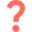
Проанализируйте полученные результаты кластеризации с помощью построенных дендрограмм и вычисленных силуэтных коэффициентов. Какая, на ваш взгляд, функция расстояния показала лучший результат и почему? Укажите, в каких случаях более предпочтительно использовать DTW меру, чем евклидову метрику.

*# WRITE YOUR ANSWER*